# Scraping the web with BeautifulSoup

We are going to get information out of websites using `requests` and `beautifulsoup`.

## Installation

With conda, you can install the required dependencies with:

```bash
conda install beautifulsoup4 requests
```

or

```bash
python3 -m pip install beautifulsoup4 requests
```


## Basic usage of BeautifulSoup

First, we import the `BeatifulSoup` class:

In [1]:
from bs4 import BeautifulSoup

We load the html source file from disk and pass the contents to the BeautifulSoup constructor.

In [2]:
with open("list.html") as f:
    html = f.read()
    document = BeautifulSoup(html, "html.parser")
print(html)

<!doctype html>
<html>
  <head>
    <title>Sample HTML document</title>
  </head>
  <body>
    <h2>An Unordered HTML List</h2>

    <ul id="unordered_list" style="color: #f0e">
      <li>Coffee</li>
      <li>Tea</li>
      <li>Milk</li>
    </ul>

    <h2>An Ordered HTML List</h2>

    <ol id="ordered_list" style="color: rgb(20, 200, 100)">
      <li>First</li>
      <li>Second</li>
      <li>Third</li>
    </ol>
  </body>
</html>



In [3]:
from IPython.display import HTML

HTML(html)

### Finding tags by name

The document now contains the full html document. We can find the first occuring tag with a specific name with the `find` function. Let's find the first un-ordered list tag:

In [4]:
ulist = document.find("ul")

The result contains all tags contained in the matched tag:

In [5]:
ulist

<ul id="unordered_list" style="color: #f0e">
<li>Coffee</li>
<li>Tea</li>
<li>Milk</li>
</ul>

The `find_all` function returns **all** tags that match the given tag name. We can use it to get a list of all list items:

In [6]:
items = ulist.find_all("li")
items

[<li>Coffee</li>, <li>Tea</li>, <li>Milk</li>]

Finally, we can loop over all items and extract their contant with the `get_text` function:

In [7]:
for item in items:
    print(repr(item.get_text()))

'Coffee'
'Tea'
'Milk'


Because whitespace is not meaningful in HTML,
it is often useful to strip it when you are getting the content of a tag.
You can do this with `strip=True`

In [8]:
for item in items:
    print(repr(item.get_text(strip=True)))

'Coffee'
'Tea'
'Milk'


Note that `find_all` is **recursive** by default. This means that we could call it the on the full `document` to get the items
of both the ordered and un-ordered lists:

In [10]:
document.find_all("li")

[<li>Coffee</li>,
 <li>Tea</li>,
 <li>Milk</li>,
 <li>First</li>,
 <li>Second</li>,
 <li>Third</li>]

In [9]:
document.find_all("li", recursive=False)

[]

In [11]:
ulist.find_all("li", recursive=False)

[<li>Coffee</li>, <li>Tea</li>, <li>Milk</li>]

A recursive search finds all `li` tags anywhere.

In [ ]:
document.find_all("li")

### Finding tags by attributes

Sometimes the easiest way to find a tag is by its attribute name. In our examples, both lists have an `id` attribute that uniquely identifies the tables. We can also use the `find*` methods to search for attributes:


In [12]:
document.find(attrs={"id": "unordered_list"})

<ul id="unordered_list" style="color: #f0e">
<li>Coffee</li>
<li>Tea</li>
<li>Milk</li>
</ul>

### Accessing attributes

The `ul` tag also contains a `style` attribute. Any bs4 tag behaves like a dictionary with attribute names as keys and attribute values as values:

In [13]:
ulist.attrs

{'id': 'unordered_list', 'style': 'color: #f0e'}

In [14]:
ulist["style"]

'color: #f0e'

## Downloading a table from Wikipedia

We aim to get a list of countries sorted by their population size:
https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population

First, let's import the required modules:

In [15]:
import re

import dateutil
import requests
from bs4 import BeautifulSoup

This time, we load the html directly from a website using the requests module:

In [16]:
url = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"

r = requests.get(url)
url

'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'

The web server returns a status code to indicate if the request was (un-)succesfully.
We use that status-code to check if the page was succesfully loaded:

In [17]:
assert r.status_code == 200

Next, we extract the html source and initiated BeautifulSoup:

In [18]:
html = r.text
document = BeautifulSoup(html, "html.parser")

by looking at the document, we can see that we are interested in first table. So we use `find`:

In [19]:
table = document.find("table", class_="wikitable")

If you are not familiar with html table, read this example first: https://www.w3schools.com/html/tryit.asp?filename=tryhtml_table_intro

In [20]:
print(str(table)[:1024])

<table class="wikitable sortable" style="text-align:right">
<tbody><tr class="is-sticky">
<th></th>
<th style="width:17em"><a href="/wiki/List_of_sovereign_states" title="List of sovereign states">Country</a> / <a href="/wiki/Dependent_territory" title="Dependent territory">Dependency</a></th>
<th>Population</th>
<th style="width:2em">% of<br/>world</th>
<th>Date</th>
<th><span class="nowrap">Source (official or from</span><br/>the <a href="/wiki/United_Nations" title="United Nations">United Nations</a>)</th>
<th class="unsortable">
</th></tr>
<tr>
<th>–
</th>
<td style="text-align:left"><b>World</b>
</td>
<td><b>8,063,588,000</b></td>
<td><b>100%</b></td>
<td><b><span data-sort-value="000000002023-10-04-0000" style="white-space:nowrap">4 Oct 2023</span></b>
</td>
<td style="text-align:left"><b>UN projection</b><sup class="reference" id="cite_ref-unpop_4-0"><a href="#cite_note-unpop-4">[3]</a></sup></td>
<td>
</td></tr>
<tr>
<th>1
</th>
<td style="text-align:left"><span class="flagicon

At this point, it is a good idea to programatically check that the table contains the correct header:

In [22]:
header = " ".join([th.get_text(strip=True) for th in table.find_all("th")])
assert "Population" in header
header

' Country/Dependency Population % ofworld Date Source (official or fromtheUnited Nations)  – 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 – 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 – 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 – 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 – 149 150 151 152 153 154 155 156 157 158 159 160 161 162 – 163 164 165 – 166 167 168 169 170 171 – 172 – 173 – – 174 – 175 176 177 – – – 178 179 180 – 181 – 182 183 184 – – 185 – 186 – – – – – – – 187 – – 188 189 190 – 191 – – – 192 – – 193 – 194 – – – – – – – – – 195 – –'

### Exercise

extract the information from the table

- get the rows
- find column names
- get sensible data from each cell
- parse numbers/dates where they show up
  

In [23]:
rows = table.find_all("tr")

In [24]:
rows[0]

<tr class="is-sticky">
<th></th>
<th style="width:17em"><a href="/wiki/List_of_sovereign_states" title="List of sovereign states">Country</a> / <a href="/wiki/Dependent_territory" title="Dependent territory">Dependency</a></th>
<th>Population</th>
<th style="width:2em">% of<br/>world</th>
<th>Date</th>
<th><span class="nowrap">Source (official or from</span><br/>the <a href="/wiki/United_Nations" title="United Nations">United Nations</a>)</th>
<th class="unsortable">
</th></tr>

In [25]:
column_names = [th.get_text(strip=True) for th in rows[0].find_all("th")]
column_names

['',
 'Country/Dependency',
 'Population',
 '% ofworld',
 'Date',
 'Source (official or fromtheUnited Nations)',
 '']

In [48]:
last_rank = 0
for row in rows[1:]:
    cells = row.find_all(["th", "td"])
    if not cells:
        continue
    cells_text = [cell.get_text(strip=True) for cell in cells]
    rank, country, population, percentage, updated_at, source, *comment = cells_text
    if not rank.isdigit():
        rank = last_rank
    else:
        last_rank = rank
        rank = int(rank)
    population = int(population.replace(",", ""))
    percentage = float(re.findall(r"[\d\.]+", percentage)[0]) / 100
    updated_at = dateutil.parser.parse(updated_at).date()

    print(rank, country, f"{population:,.2e}", f"{percentage:.1%}", updated_at)

0 World 8.06e+09 100.0% 2023-10-04
1 China 1.41e+09 17.5% 2022-12-31
2 India 1.39e+09 17.3% 2023-03-01
3 United States 3.35e+08 4.2% 2023-10-04
4 Indonesia 2.79e+08 3.5% 2023-07-01
5 Pakistan 2.41e+08 3.0% 2023-03-01
6 Nigeria 2.17e+08 2.7% 2022-03-21
7 Brazil 2.03e+08 2.5% 2022-08-01
8 Bangladesh 1.70e+08 2.1% 2022-06-14
9 Russia 1.46e+08 1.8% 2023-01-01
10 Mexico 1.29e+08 1.6% 2023-06-30
11 Japan 1.24e+08 1.5% 2023-09-01
12 Philippines 1.11e+08 1.4% 2023-10-04
13 Ethiopia 1.07e+08 1.3% 2023-07-01
14 Egypt 1.05e+08 1.3% 2023-10-04
15 Vietnam 1.00e+08 1.2% 2023-04-04
16 DR Congo 9.54e+07 1.2% 2019-07-01
17 Iran 8.53e+07 1.1% 2023-10-04
18 Turkey 8.53e+07 1.1% 2022-12-31
19 Germany 8.45e+07 1.0% 2023-06-30
20 Thailand 6.83e+07 0.8% 2021-07-01
21 France 6.82e+07 0.8% 2023-09-01
22 United Kingdom 6.70e+07 0.8% 2021-06-30
23 Tanzania 6.17e+07 0.8% 2022-08-23
24 South Africa 6.06e+07 0.8% 2022-07-01
25 Italy 5.88e+07 0.7% 2023-07-31
26 Myanmar 5.58e+07 0.7% 2022-07-01
27 Colombia 5.22e+07 0

**Attention**: Beautiful Soup does not execute Javascript. This means that you the code in your browser inspector might look a bit different from the original HTML source code. 

# Another example of downloading a Wikipedia table 

Let's consider another table in a Wikipedia page. This page has a lot more tables, so one challenge will be to pick the right table

https://en.wikipedia.org/wiki/Serena_Williams


We are interested in extracting these two tables:

![Target Wikipedia tables](figs/wiki_tables.png)

**Exercise**: 

Find the tables on a page by locating heading and using `.find_next()`


We begin by downloading the webpage and instatiating the BeautifulSoup object:

In [49]:
r = requests.get("https://en.wikipedia.org/wiki/Serena_Williams")
document = BeautifulSoup(r.text, "html.parser")

This page contains a lot of tables without specific attributes that would make it easy to find our table of interest. Further, the same headings of the tables are used for multiple tables, making it difficult to find a table just by its headings:

In [50]:
len(document.find_all("table"))

75

Therefore, we choose another strategy.

First, we find the tag with class `mw-headling` whose `string` content _starts with_ `Singles`.
Then we find the _next_ table using `heading_element.find_next(...)`:

In [51]:
document.find_all(class_="mw-headline", string=re.compile("^Singles"))

[<span class="mw-headline" id="Singles:_33_(23–10)">Singles: 33 (23–10)</span>]

In [52]:
# string class
singles_heading = document.find(class_="mw-headline", string=re.compile("^Singles"))
singles_heading

<span class="mw-headline" id="Singles:_33_(23–10)">Singles: 33 (23–10)</span>

In [53]:
singles_heading.find_next("table")

<table class="sortable wikitable">
<tbody><tr>
<th>Result
</th>
<th>Year
</th>
<th>Tournament
</th>
<th>Surface
</th>
<th>Opponents
</th>
<th class="unsortable">Score
</th></tr>
<tr style="background:#ccf;">
<td style="background:#98fb98;">Win</td>
<td><a href="/wiki/1999_US_Open_%E2%80%93_Women%27s_singles" title="1999 US Open – Women's singles">1999</a></td>
<td><a href="/wiki/US_Open_(tennis)" title="US Open (tennis)">US Open</a></td>
<td><a class="mw-redirect" href="/wiki/Hard_court" title="Hard court">Hard</a></td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="/wiki/Switzerland" title="Switzerland"><img alt="Switzerland" class="mw-file-element" data-file-height="512" data-file-width="512" decoding="async" height="16" src="//upload.wikimedia.org/wikipedia/commons/thumb/0/08/Flag_of_Switzerland_%28Pantone%29.svg/16px-Flag_of_Switzerland_%28Pantone%29.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/0/08/Flag_of_Switzerland_%28Panto

Now, our tables of interest are the first two result tables for "Singles" and "Women's doubles". We write a small helper function that returns a table with a given heading:

In [54]:
def find_table_with_heading(document, heading_pat):
    heading_element = document.find(class_="mw-headline", string=heading_pat)
    table = heading_element.find_next("table")
    return table

In [55]:
singles_table = find_table_with_heading(document, re.compile("^Singles"))
# print headers
headings = singles_table.find_all("th")
[th.get_text(strip=True) for th in headings]

['Result', 'Year', 'Tournament', 'Surface', 'Opponents', 'Score']

Next, we can find the table after the heading "Women's doubles"

In [56]:
doubles_table = find_table_with_heading(document, re.compile(r"^Women's doubles"))
# print headers
headings = doubles_table.find_all("th")
[th.get_text(strip=True) for th in headings]

['Result', 'Year', 'Tournament', 'Surface', 'Partner', 'Opponents', 'Score']

## Exercise:

- Iterate through the rows
- convert year to integer (or date)
- strip note '(12)' from event, so the same event has the same string
- load into pandas DataFrame (more on pandas in a later lecture)

In [ ]:
re.sub?

In [61]:
data = []
for row in singles_table.find_all("tr"):
    cells = row.find_all("td")
    if not cells:
        continue
    values = [cell.get_text(strip=True) for cell in cells]
    values[1] = int(values[1])
    values[2] = re.sub(r"\s*\(.+\)", "", values[2])
    print(values)
    data.append(values)

['Win', 1999, 'US Open', 'Hard', 'Martina Hingis', '6–3, 7–6(7–4)']
['Loss', 2001, 'US Open', 'Hard', 'Venus Williams', '2–6, 4–6']
['Win', 2002, 'French Open', 'Clay', 'Venus Williams', '7–5, 6–3']
['Win', 2002, 'Wimbledon', 'Grass', 'Venus Williams', '7–6(7–4), 6–3']
['Win', 2002, 'US Open', 'Hard', 'Venus Williams', '6–4, 6–3']
['Win', 2003, 'Australian Open', 'Hard', 'Venus Williams', '7–6(7–4), 3–6, 6–4']
['Win', 2003, 'Wimbledon', 'Grass', 'Venus Williams', '4–6, 6–4, 6–2']
['Loss', 2004, 'Wimbledon', 'Grass', 'Maria Sharapova', '1–6, 4–6']
['Win', 2005, 'Australian Open', 'Hard', 'Lindsay Davenport', '2–6, 6–3, 6–0']
['Win', 2007, 'Australian Open', 'Hard', 'Maria Sharapova', '6–1, 6–2']
['Loss', 2008, 'Wimbledon', 'Grass', 'Venus Williams', '5–7, 4–6']
['Win', 2008, 'US Open', 'Hard', 'Jelena Janković', '6–4, 7–5']
['Win', 2009, 'Australian Open', 'Hard', 'Dinara Safina', '6–0, 6–3']
['Win', 2009, 'Wimbledon', 'Grass', 'Venus Williams', '7–6(7–3), 6–2']
['Win', 2010, 'Australia

When data is in this form, we can convert it into a DataFrame with pandas.

You'll learn more about pandas next week.

In [62]:
import pandas as pd

headings = [th.get_text(strip=True) for th in singles_table.find_all("th")]
df = pd.DataFrame(data, columns=headings)
df

,Result,Year,Tournament,Surface,Opponents,Score
0,Win,1999,US Open,Hard,Martina Hingis,"6–3, 7–6(7–4)"
1,Loss,2001,US Open,Hard,Venus Williams,"2–6, 4–6"
2,Win,2002,French Open,Clay,Venus Williams,"7–5, 6–3"
3,Win,2002,Wimbledon,Grass,Venus Williams,"7–6(7–4), 6–3"
4,Win,2002,US Open,Hard,Venus Williams,"6–4, 6–3"
5,Win,2003,Australian Open,Hard,Venus Williams,"7–6(7–4), 3–6, 6–4"
6,Win,2003,Wimbledon,Grass,Venus Williams,"4–6, 6–4, 6–2"
7,Loss,2004,Wimbledon,Grass,Maria Sharapova,"1–6, 4–6"
8,Win,2005,Australian Open,Hard,Lindsay Davenport,"2–6, 6–3, 6–0"
9,Win,2007,Australian Open,Hard,Maria Sharapova,"6–1, 6–2"


With pandas, we can filter this data, group it, and plot interesting relationships.

Pandas `groupby` is an interesting operation for performing aggregations,
e.g. counting the wins/losses by year and result:

In [63]:
df.Result.value_counts()

Result
Win     23
Loss    10
Name: count, dtype: int64

In [64]:
results_by_year = df.groupby(["Year", "Result"]).Tournament.count().unstack().fillna(0)
results_by_year

Result,Loss,Win
Year,,
1999,0.0,1.0
2001,1.0,0.0
2002,0.0,3.0
2003,0.0,2.0
2004,1.0,0.0
2005,0.0,1.0
2007,0.0,1.0
2008,1.0,1.0
2009,0.0,2.0


Which we can now plot

<Axes: xlabel='Year'>

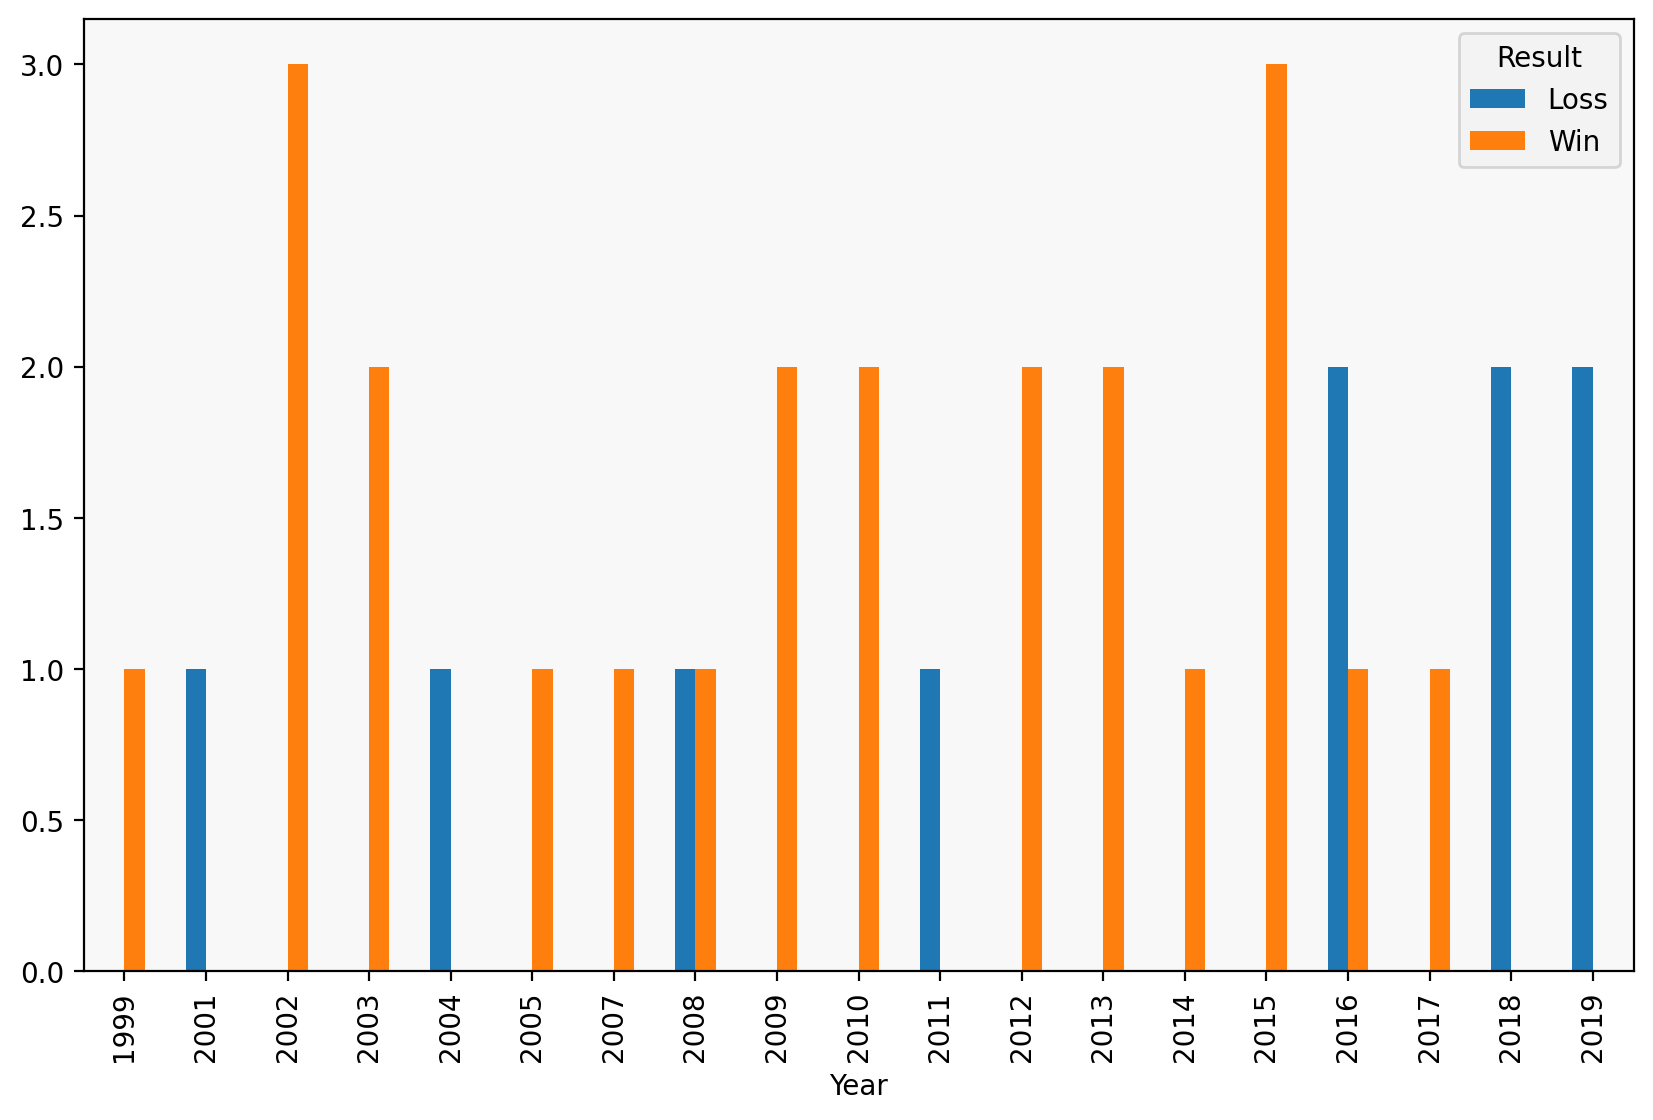

In [65]:
results_by_year.plot(kind="bar", grid=False)

Is there any significance to the court?

In [68]:
results_by_surface = df.groupby(["Surface", "Result"]).Tournament.count().unstack()
results_by_surface

Result,Loss,Win
Tournament,,
Australian Open,1,7
French Open,1,3
US Open,4,6
Wimbledon,4,7


<Axes: xlabel='Tournament'>

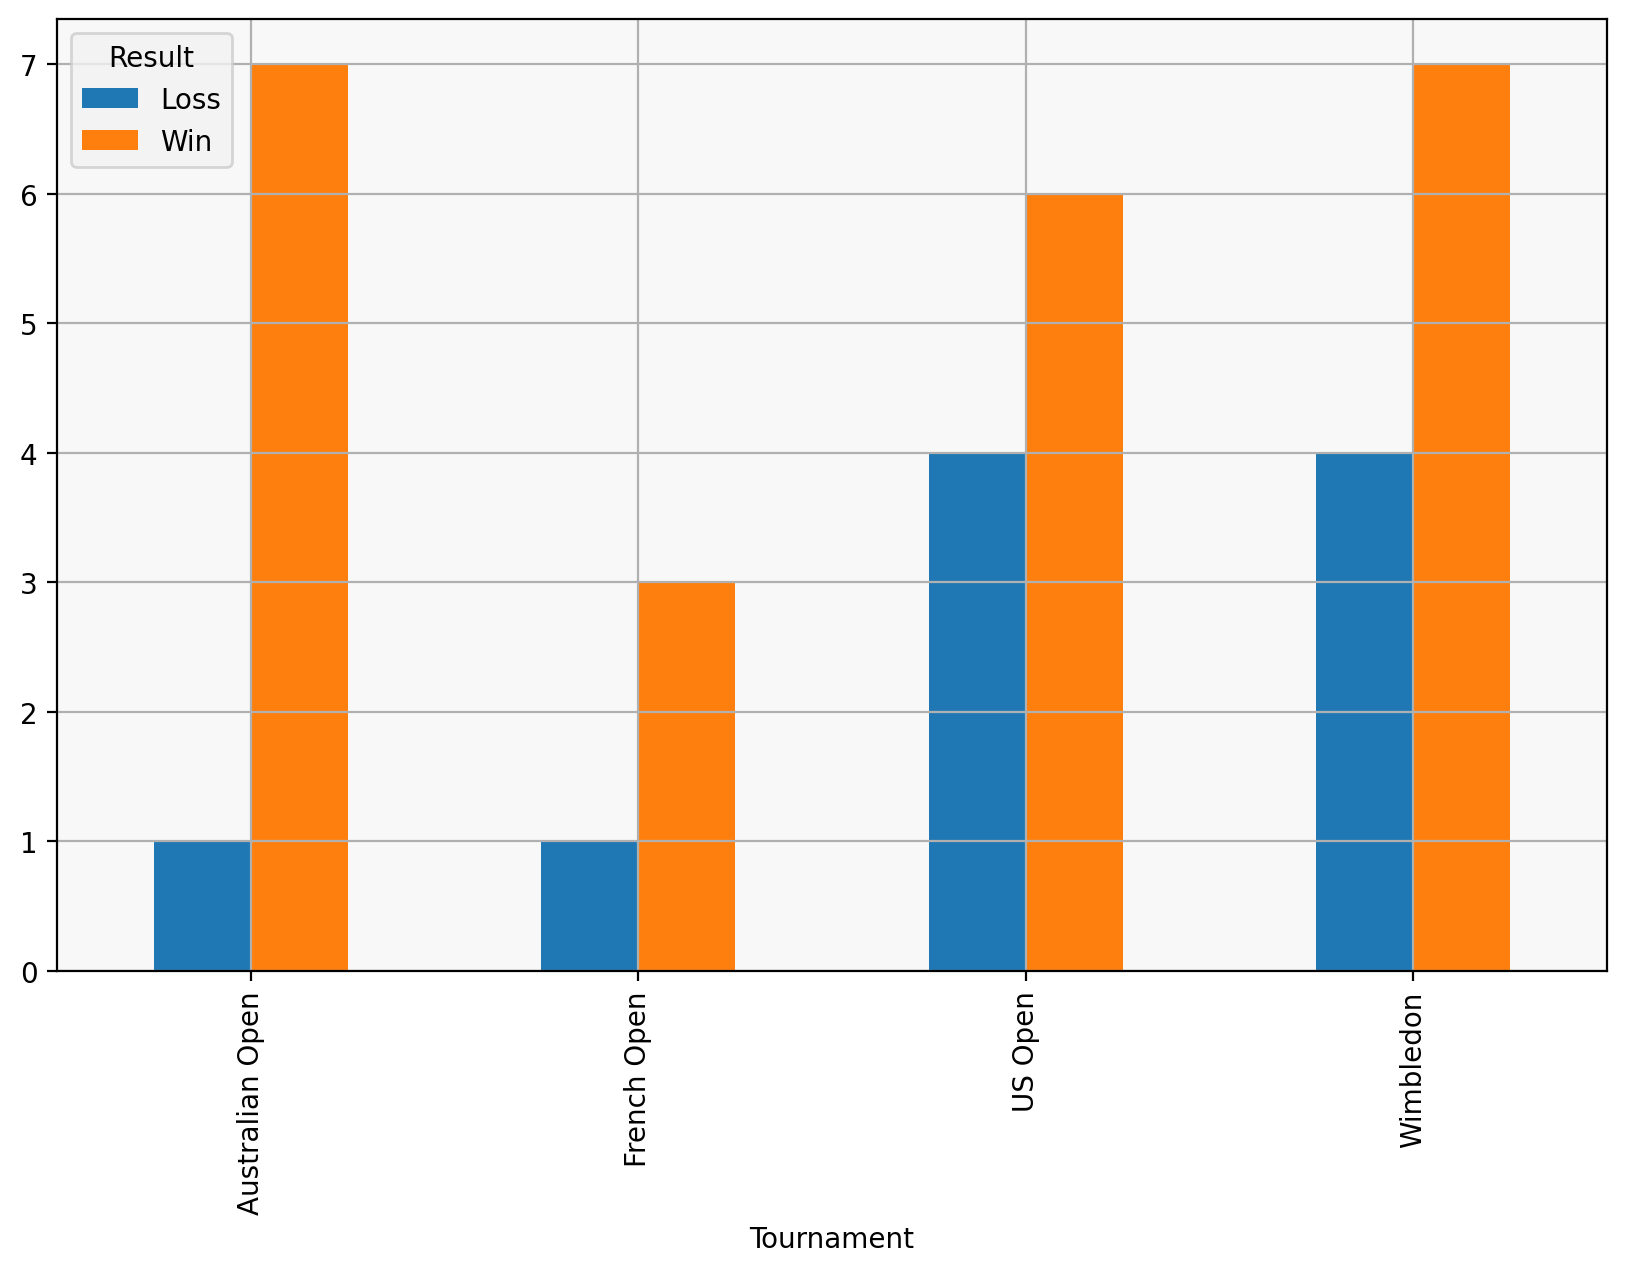

In [69]:
results_by_surface.plot(kind="bar")

We can even filter to e.g. select opponents who Williams faced at least twice

In [70]:
results_by_op = df.groupby(["Opponents", "Result"]).Tournament.count().unstack()
results_by_op

Result,Loss,Win
Opponents,,
Agnieszka Radwańska,NaN,1.0
Angelique Kerber,2.0,1.0
Bianca Andreescu,1.0,NaN
Caroline Wozniacki,NaN,1.0
Dinara Safina,NaN,1.0
Garbiñe Muguruza,1.0,1.0
Jelena Janković,NaN,1.0
Justine Henin,NaN,1.0
Lindsay Davenport,NaN,1.0


In [71]:
# we can exclude opponents only met once:
results_by_op = results_by_op.fillna(0)
results_by_op

Result,Loss,Win
Opponents,,
Agnieszka Radwańska,0.0,1.0
Angelique Kerber,2.0,1.0
Bianca Andreescu,1.0,0.0
Caroline Wozniacki,0.0,1.0
Dinara Safina,0.0,1.0
Garbiñe Muguruza,1.0,1.0
Jelena Janković,0.0,1.0
Justine Henin,0.0,1.0
Lindsay Davenport,0.0,1.0


In [72]:
(results_by_op.Win + results_by_op.Loss) > 1

Opponents
Agnieszka Radwańska    False
Angelique Kerber        True
Bianca Andreescu       False
Caroline Wozniacki     False
Dinara Safina          False
Garbiñe Muguruza        True
Jelena Janković        False
Justine Henin          False
Lindsay Davenport      False
Lucie Šafářová         False
Maria Sharapova         True
Martina Hingis         False
Naomi Osaka            False
Samantha Stosur        False
Simona Halep           False
Venus Williams          True
Vera Zvonareva         False
Victoria Azarenka       True
dtype: bool

<Axes: xlabel='Opponents'>

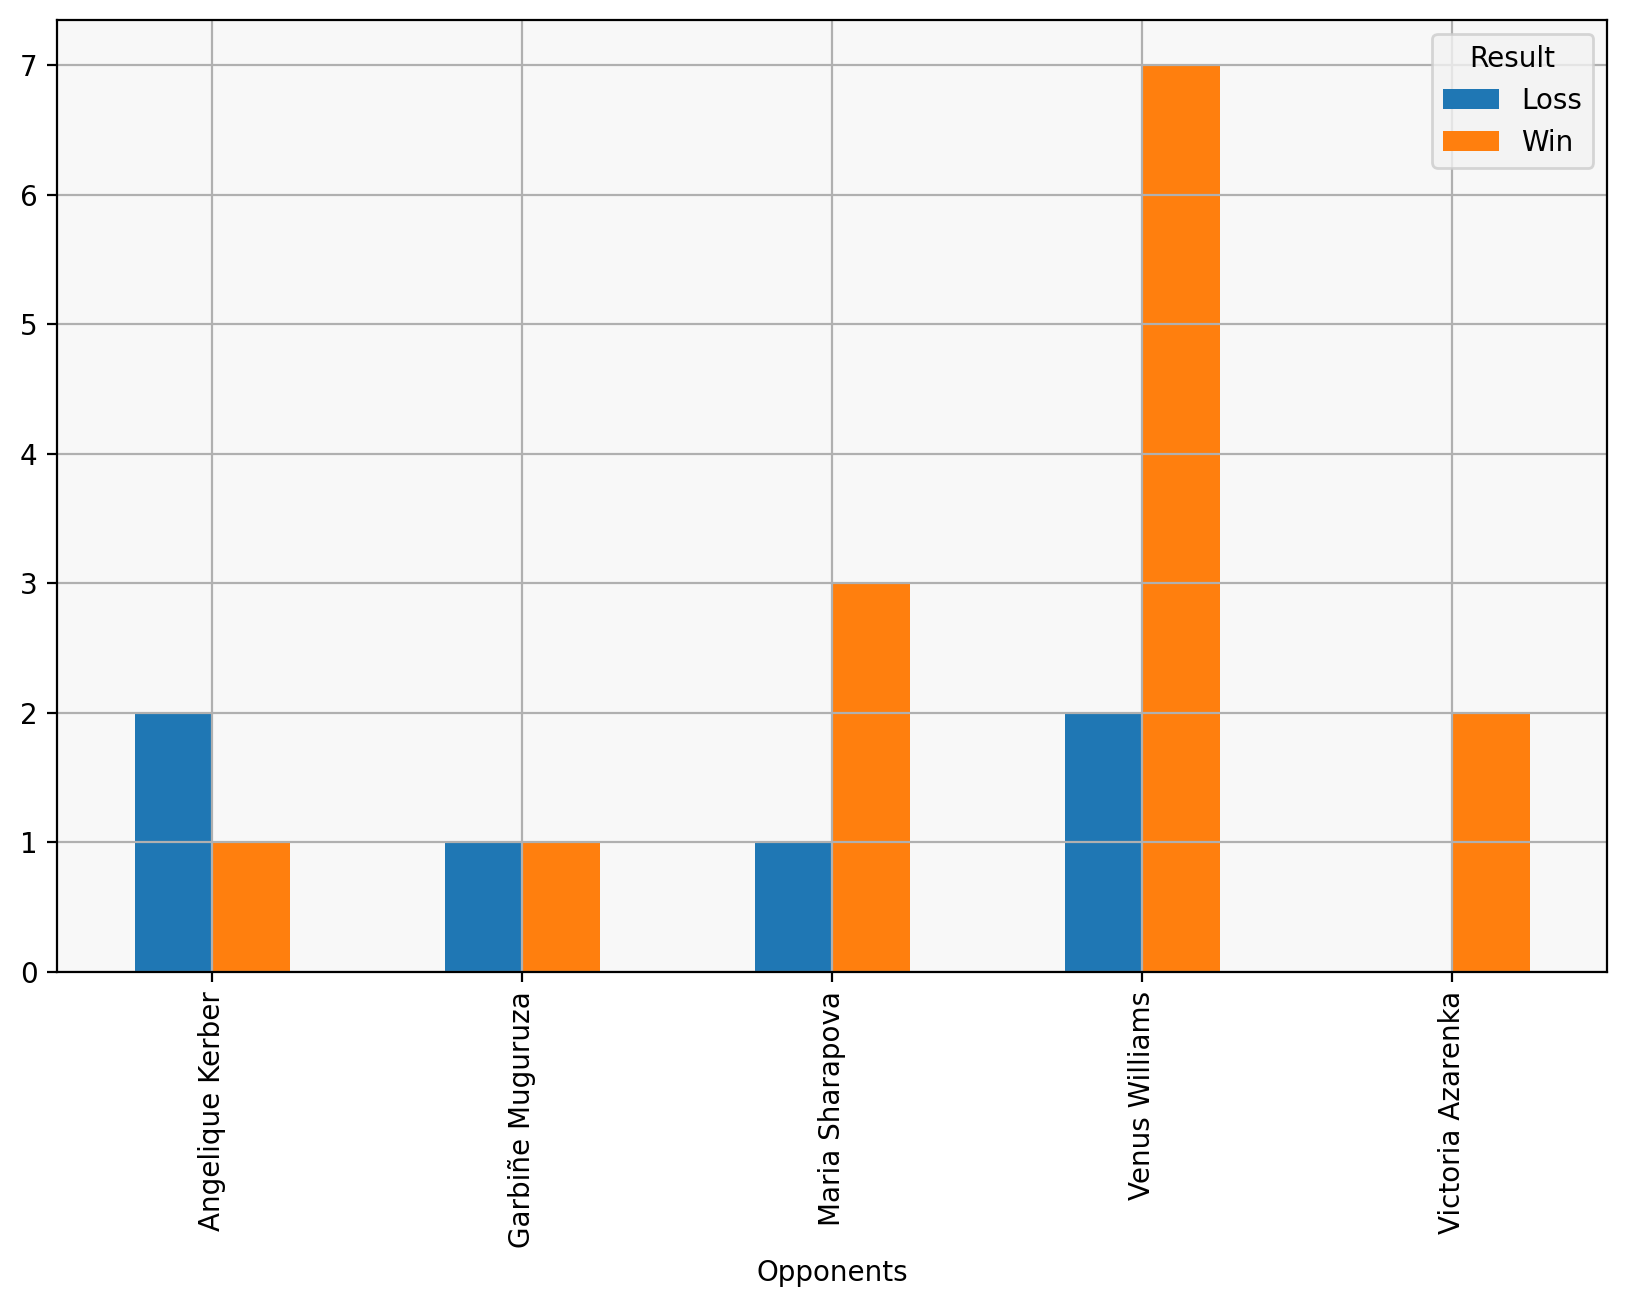

In [73]:
multiple_meetings = results_by_op[(results_by_op.Win + results_by_op.Loss) > 1]
multiple_meetings.plot(kind="bar")

# Exercise:

Find images on the UiO page

1) Go to https://en.wikipedia.org/wiki/University_of_Oslo 
2) Download the content from the site using BeautifulSoup and requests
3) Search for all images (using `images = document.find_all('img')`) and print out the content
4) Include only images with the attribute `class_="mw-file-element"` in your list of images.
5) Print out a list of the value of the "src" attribute for the images in 4. 
6) See if you can display an image by pasting a result from 5 into your web-browser.

In [74]:
r = requests.get("https://no.wikipedia.org/wiki/Universitetet_i_Oslo")
html = r.text
print(html[:400])

<!DOCTYPE html>
<html class="client-nojs" lang="nb" dir="ltr">
<head>
<meta charset="UTF-8">
<title>Universitetet i Oslo – Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":[",\t."," \t,"],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","januar","februar","mars","april","mai","juni","jul


In [75]:
document = BeautifulSoup(html, "html.parser")

In [85]:
images = document.find_all("img", class_="mw-file-element")
len(images)

17

In [89]:
for image in images:
    print(image["src"])

<img alt="Rediger på Wikidata" class="mw-file-element" data-file-height="20" data-file-width="20" decoding="async" height="10" src="//upload.wikimedia.org/wikipedia/commons/thumb/8/8a/OOjs_UI_icon_edit-ltr-progressive.svg/10px-OOjs_UI_icon_edit-ltr-progressive.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/8/8a/OOjs_UI_icon_edit-ltr-progressive.svg/15px-OOjs_UI_icon_edit-ltr-progressive.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/8/8a/OOjs_UI_icon_edit-ltr-progressive.svg/20px-OOjs_UI_icon_edit-ltr-progressive.svg.png 2x" width="10"/>
<img alt="Rediger på Wikidata" class="mw-file-element" data-file-height="20" data-file-width="20" decoding="async" height="10" src="//upload.wikimedia.org/wikipedia/commons/thumb/8/8a/OOjs_UI_icon_edit-ltr-progressive.svg/10px-OOjs_UI_icon_edit-ltr-progressive.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/8/8a/OOjs_UI_icon_edit-ltr-progressive.svg/15px-OOjs_UI_icon_edit-ltr-progressive.svg.png 1.5x, //up

In [87]:
from IPython.display import HTML, display

In [88]:
for image in images:
    url = image["src"]
    if "://" in url:
        pass
    elif url.startswith("//"):
        # add 'scheme' or 'protocol'
        url = "https:" + url
    elif url.startswith("/"):
        url = "https://no.wikipedia.org" + url
    else:
        # not an understood URL
        raise ValueError(f"I don't understand this url: {url}")
    html = HTML(f'<img src="{url}">')
    display(html)